In [1]:
install.packages("sparklyr")

also installing the dependencies ‘DBI’, ‘config’, ‘rappdirs’, ‘withr’, ‘shiny’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [2]:
library("sparklyr")

In [3]:
sc <- spark_connect(master = "local")

In [4]:
install.packages(c("nycflights13", "Lahman"))

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [5]:
library(dplyr)
iris_tbl <- copy_to(sc, iris)
flights_tbl <- copy_to(sc, nycflights13::flights, "flights")
batting_tbl <- copy_to(sc, Lahman::Batting, "batting")
src_tbls(sc)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



[1] "batting" "flights" "iris"

In [6]:
flights_tbl %>% filter(dep_delay == 2)

Source:   query [6,233 x 19]
Database: spark connection master=local[4] app=sparklyr local=TRUE

    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
1   2013     1     1      517            515         2      830            819
2   2013     1     1      542            540         2      923            850
3   2013     1     1      702            700         2     1058           1014
4   2013     1     1      715            713         2      911            850
5   2013     1     1      752            750         2     1025           1029
6   2013     1     1      917            915         2     1206           1211
7   2013     1     1      932            930         2     1219           1225
8   2013     1     1     1028           1026         2     1350           1339
9   2013     1     1     1042           1040         2     1325           1326
10  2013     1     1     1231     

In [7]:
delay <- flights_tbl %>% 
  group_by(tailnum) %>%
  summarise(count = n(), dist = mean(distance), delay = mean(arr_delay)) %>%
  filter(count > 20, dist < 2000, !is.na(delay)) %>%
  collect

`geom_smooth()` using method = 'gam'


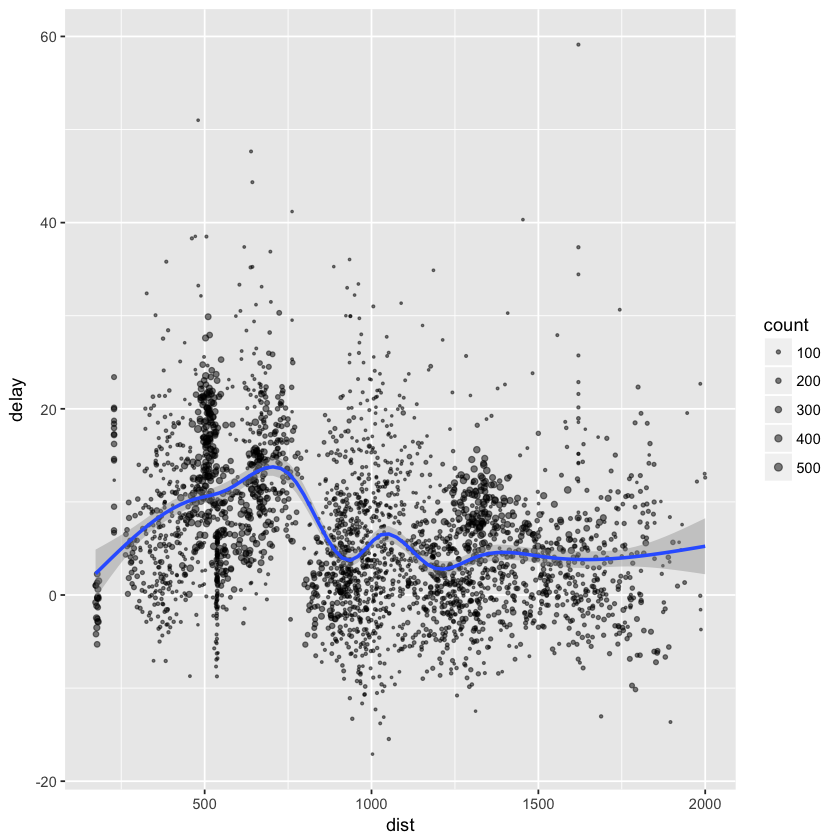

In [8]:
library(ggplot2)
ggplot(delay, aes(dist, delay)) +
  geom_point(aes(size = count), alpha = 1/2) +
  geom_smooth() +
  scale_size_area(max_size = 2)

In [9]:
batting_tbl %>%
  select(playerID, yearID, teamID, G, AB:H) %>%
  arrange(playerID, yearID, teamID) %>%
  group_by(playerID) %>%
  filter(min_rank(desc(H)) <= 2 & H > 0)

Source:   query [2.562e+04 x 7]
Database: spark connection master=local[4] app=sparklyr local=TRUE
Groups: playerID

    playerID yearID teamID     G    AB     R     H
       <chr>  <int>  <chr> <int> <int> <int> <int>
1   abadan01   2003    BOS     9    17     1     2
2  abbated01   1905    BSN   153   610    70   170
3  abbated01   1904    BSN   154   579    76   148
4  abbotda01   1890    TL2     3     7     0     1
5  abbotod01   1910    SLN    22    70     2    13
6  abbotpa01   2000    SEA    35     5     1     2
7  abbotpa01   2004    PHI    10    11     1     2
8   aberal01   1954    DET    32    39     3     5
9   aberal01   1953    DET    17    23     2     3
10  aberal01   1956    DET    42    10     0     3
# ... with 2.561e+04 more rows

In [10]:
library(DBI)
iris_preview <- dbGetQuery(sc, "SELECT * FROM iris LIMIT 10")
iris_preview

Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa
4.6,3.4,1.4,0.3,setosa
5.0,3.4,1.5,0.2,setosa
4.4,2.9,1.4,0.2,setosa
4.9,3.1,1.5,0.1,setosa


In [11]:
mtcars_tbl <- copy_to(sc, mtcars)

In [12]:
partitions <- mtcars_tbl %>%
  filter(hp >= 100) %>%
  mutate(cyl8 = cyl == 8) %>%
  sdf_partition(training = 0.5, test = 0.5, seed = 1099)

In [13]:
fit <- partitions$training %>%
  ml_linear_regression(response = "mpg", features = c("wt", "cyl"))

* No rows dropped by 'na.omit' call


In [14]:
fit

Call: ml_linear_regression(., response = "mpg", features = c("wt", "cyl"))

Coefficients:
(Intercept)          wt         cyl 
  37.066699   -2.309504   -1.639546 


In [15]:
summary(fit)

Call: ml_linear_regression(., response = "mpg", features = c("wt", "cyl"))

Deviance Residuals::
    Min      1Q  Median      3Q     Max 
-2.6881 -1.0507 -0.4420  0.4757  3.3858 

Coefficients:
            Estimate Std. Error t value  Pr(>|t|)    
(Intercept) 37.06670    2.76494 13.4059 2.981e-07 ***
wt          -2.30950    0.84748 -2.7252   0.02341 *  
cyl         -1.63955    0.58635 -2.7962   0.02084 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-Squared: 0.8665
Root Mean Squared Error: 1.799


In [16]:
spark_disconnect(sc)